In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from scipy import stats
from sklearn.cross_validation import KFold
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
%matplotlib inline

/opt/conda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
xtrain = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")


#  EDA

In [3]:
train.head()

id cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9   ...        cont6  \
0   1    A    B    A    B    A    A    A    A    B   ...     0.718367   
1   2    A    B    A    A    A    A    A    A    B   ...     0.438917   
2   5    A    B    A    A    B    A    A    A    B   ...     0.289648   
3  10    B    B    A    B    A    A    A    A    B   ...     0.440945   
4  11    A    B    A    B    A    A    A    A    B   ...     0.178193   

      cont7    cont8    cont9   cont10    cont11    cont12    cont13  \
0  0.335060  0.30260  0.67135  0.83510  0.569745  0.594646  0.822493   
1  0.436585  0.60087  0.35127  0.43919  0.338312  0.366307  0.611431   
2  0.315545  0.27320  0.26076  0.32446  0.381398  0.373424  0.195709   
3  0.391128  0.31796  0.32128  0.44467  0.327915  0.321570  0.605077   
4  0.247408  0.24564  0.22089  0.21230  0.204687  0.202213  0.246011   

     cont14     loss  
0  0.714843  2213.18  
1  0.304496  1283.60  
2  0.774425  3005.09  
3  0.602642   939.85  
4  0.432606  2763.85  

[5 rows x 132 columns]

In [8]:
train.describe(include=['O'])

cat1    cat2    cat3    cat4    cat5    cat6    cat7    cat8  \
count   188318  188318  188318  188318  188318  188318  188318  188318   
unique       2       2       2       2       2       2       2       2   
top          A       A       A       A       A       A       A       A   
freq    141550  106721  177993  128395  123737  131693  183744  177274   

          cat9   cat10   ...    cat107  cat108  cat109  cat110  cat111  \
count   188318  188318   ...    188318  188318  188318  188318  188318   
unique       2       2   ...        20      11      84     131      16   
top          A       A   ...         F       B      BI      CL       A   
freq    113122  160213   ...     47310   65512  152918   25305  128395   

        cat112  cat113  cat114  cat115  cat116  
count   188318  188318  188318  188318  188318  
unique      51      61      19      23     326  
top          E      BM       A       K      HK  
freq     25148   26191  131693   43866   21061  

[4 rows x 116 columns]

In [9]:
train.describe()

id          cont1          cont2          cont3  \
count  188318.000000  188318.000000  188318.000000  188318.000000   
mean   294135.982561       0.493861       0.507188       0.498918   
std    169336.084867       0.187640       0.207202       0.202105   
min         1.000000       0.000016       0.001149       0.002634   
25%    147748.250000       0.346090       0.358319       0.336963   
50%    294539.500000       0.475784       0.555782       0.527991   
75%    440680.500000       0.623912       0.681761       0.634224   
max    587633.000000       0.984975       0.862654       0.944251   

               cont4          cont5          cont6          cont7  \
count  188318.000000  188318.000000  188318.000000  188318.000000   
mean        0.491812       0.487428       0.490945       0.484970   
std         0.211292       0.209027       0.205273       0.178450   
min         0.176921       0.281143       0.012683       0.069503   
25%         0.327354       0.281143       0.336105       0.350175   
50%         0.452887       0.422268       0.440945       0.438285   
75%         0.652072       0.643315       0.655021       0.591045   
max         0.954297       0.983674       0.997162       1.000000   

               cont8          cont9         cont10         cont11  \
count  188318.000000  188318.000000  188318.000000  188318.000000   
mean        0.486437       0.485506       0.498066       0.493511   
std         0.199370       0.181660       0.185877       0.209737   
min         0.236880       0.000080       0.000000       0.035321   
25%         0.312800       0.358970       0.364580       0.310961   
50%         0.441060       0.441450       0.461190       0.457203   
75%         0.623580       0.566820       0.614590       0.678924   
max         0.980200       0.995400       0.994980       0.998742   

              cont12         cont13         cont14           loss  
count  188318.000000  188318.000000  188318.000000  188318.000000  
mean        0.493150       0.493138       0.495717    3037.337686  
std         0.209427       0.212777       0.222488    2904.086186  
min         0.036232       0.000228       0.179722       0.670000  
25%         0.311661       0.315758       0.294610    1204.460000  
50%         0.462286       0.363547       0.407403    2115.570000  
75%         0.675759       0.689974       0.724623    3864.045000  
max         0.998484       0.988494       0.844848  121012.250000

In [3]:
train['loss'] = np.log(train['loss']+200)

In [4]:
train_con = train.select_dtypes(include= ['Float64']) 
train_cat = train.select_dtypes(include=['object'])

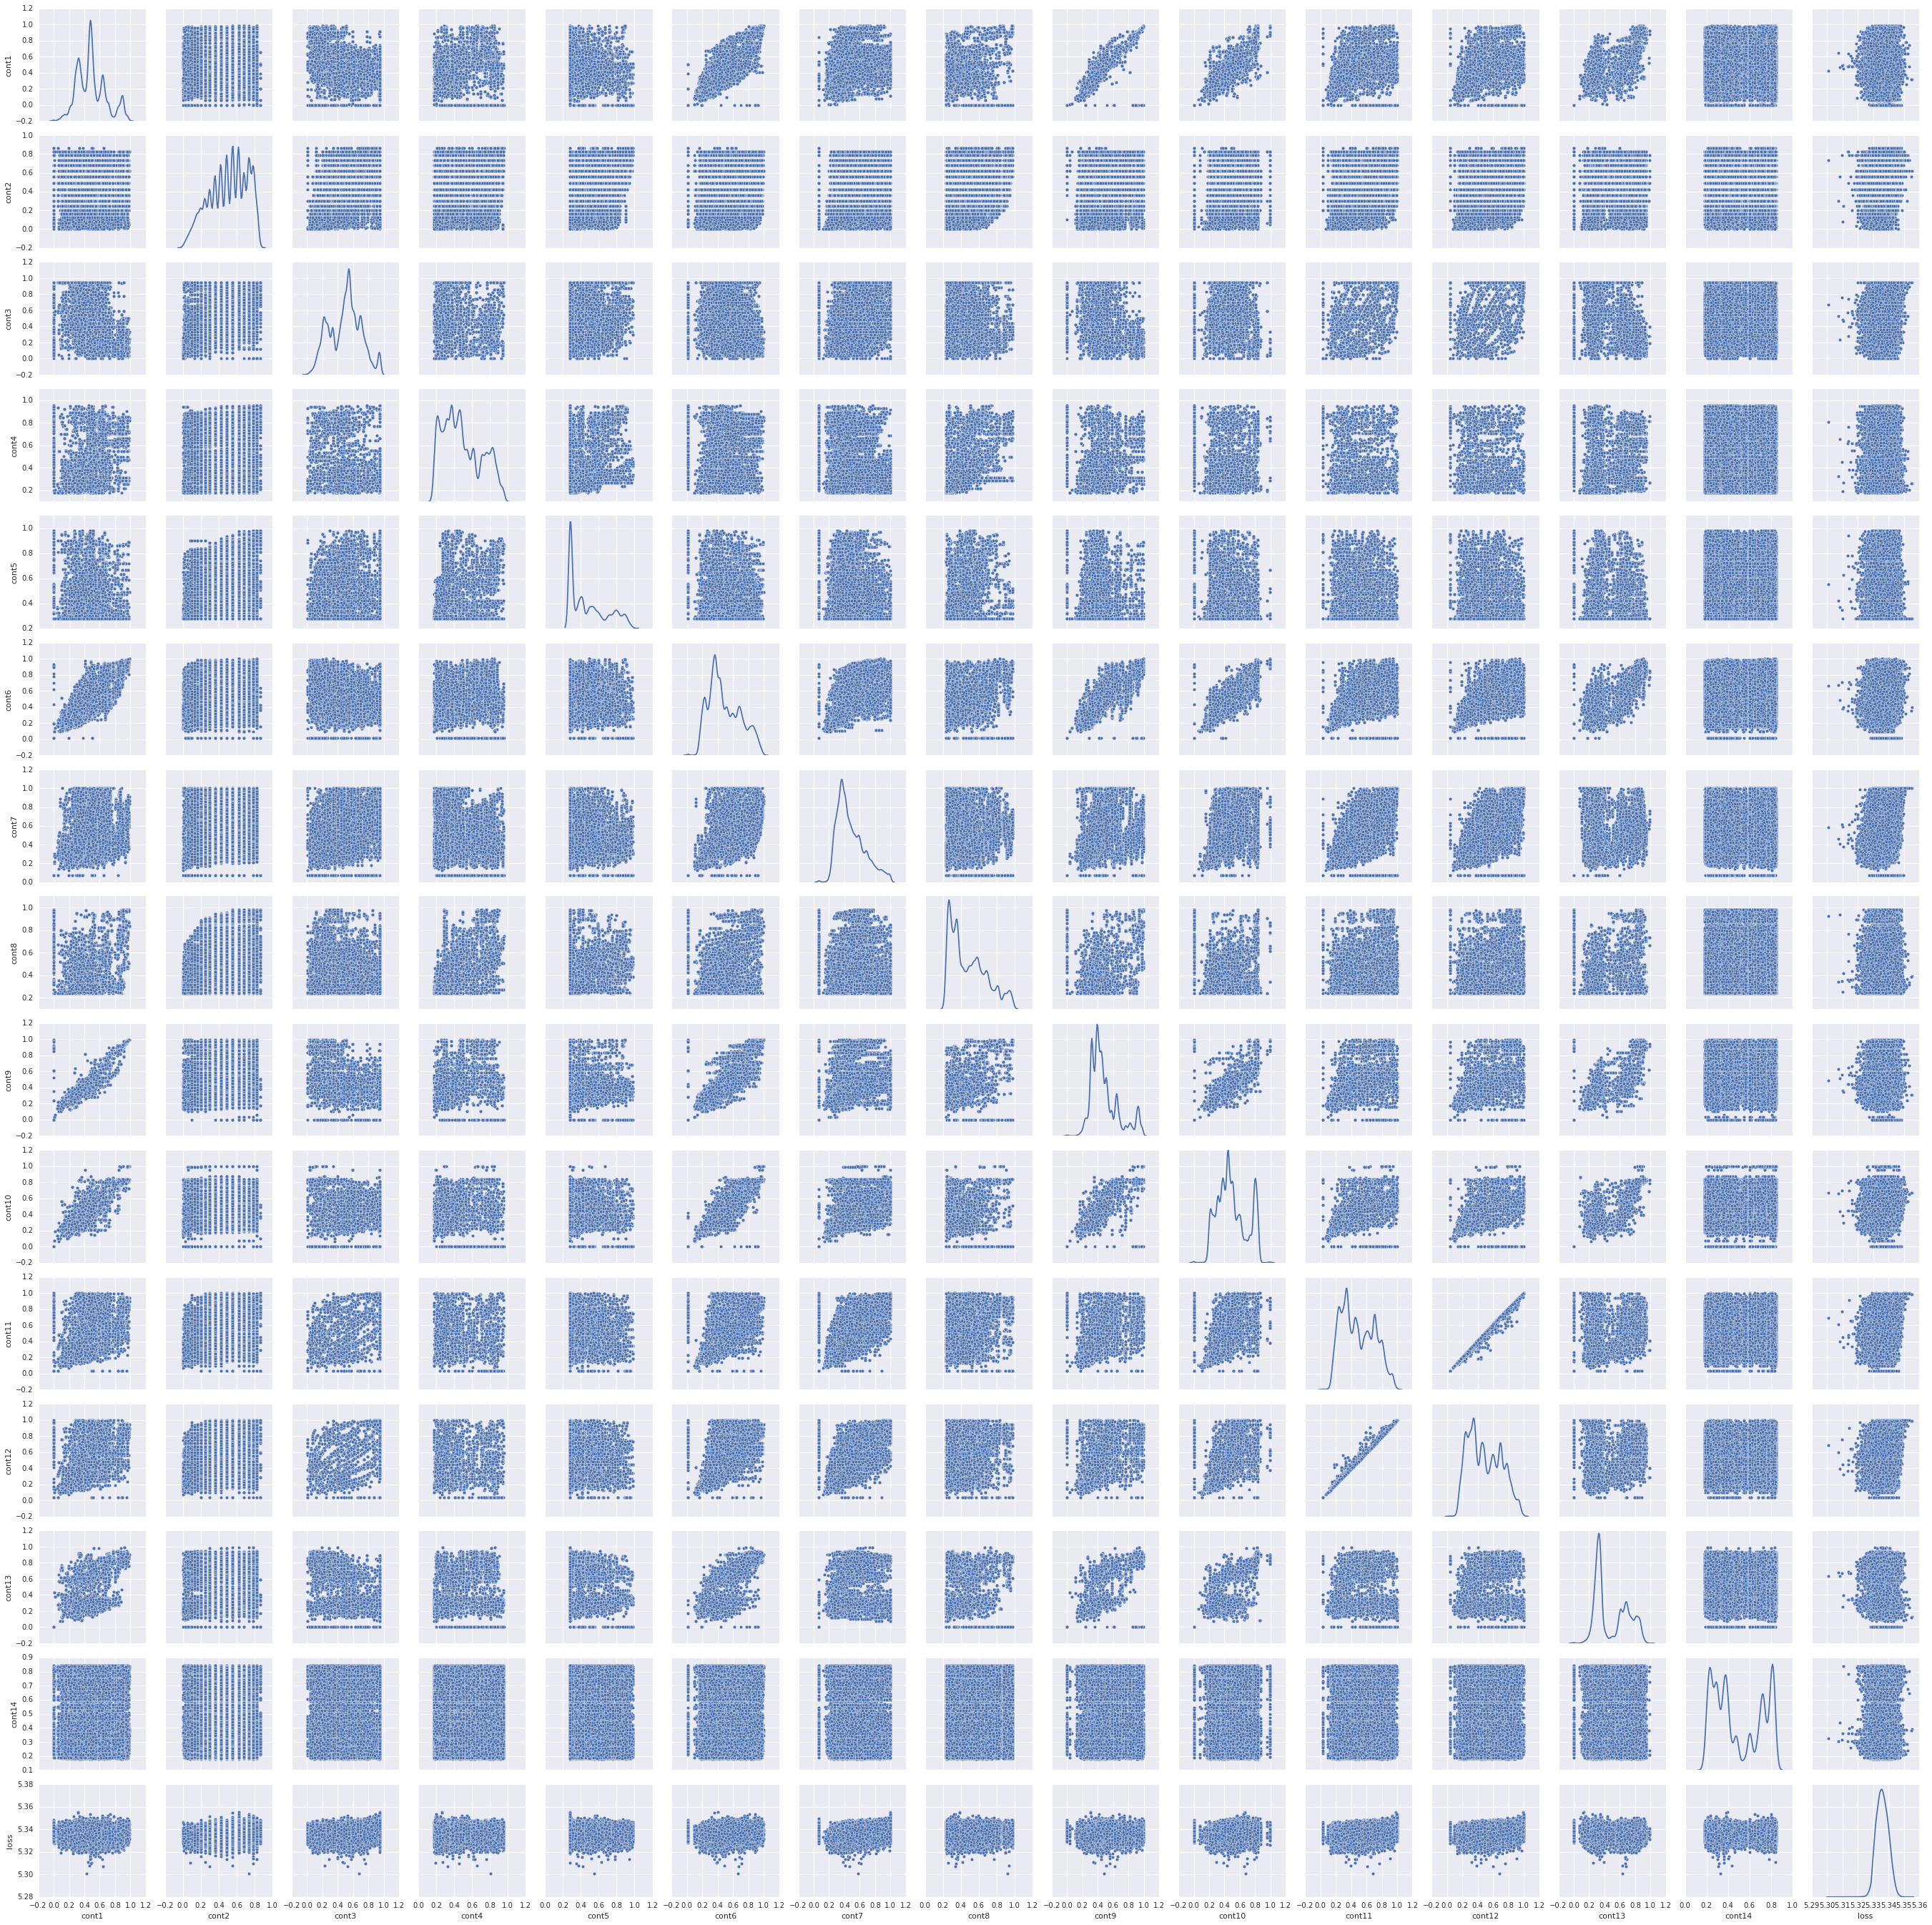

In [37]:
sns.pairplot(train_con, kind = 'scatter',diag_kind='kde')

In [5]:
#compare the distribution of continuous variables
cont_columns = train_con.drop('loss', axis = 1)

In [6]:
cont_columns.columns

Index(['cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8',
       'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14'],
      dtype='object')

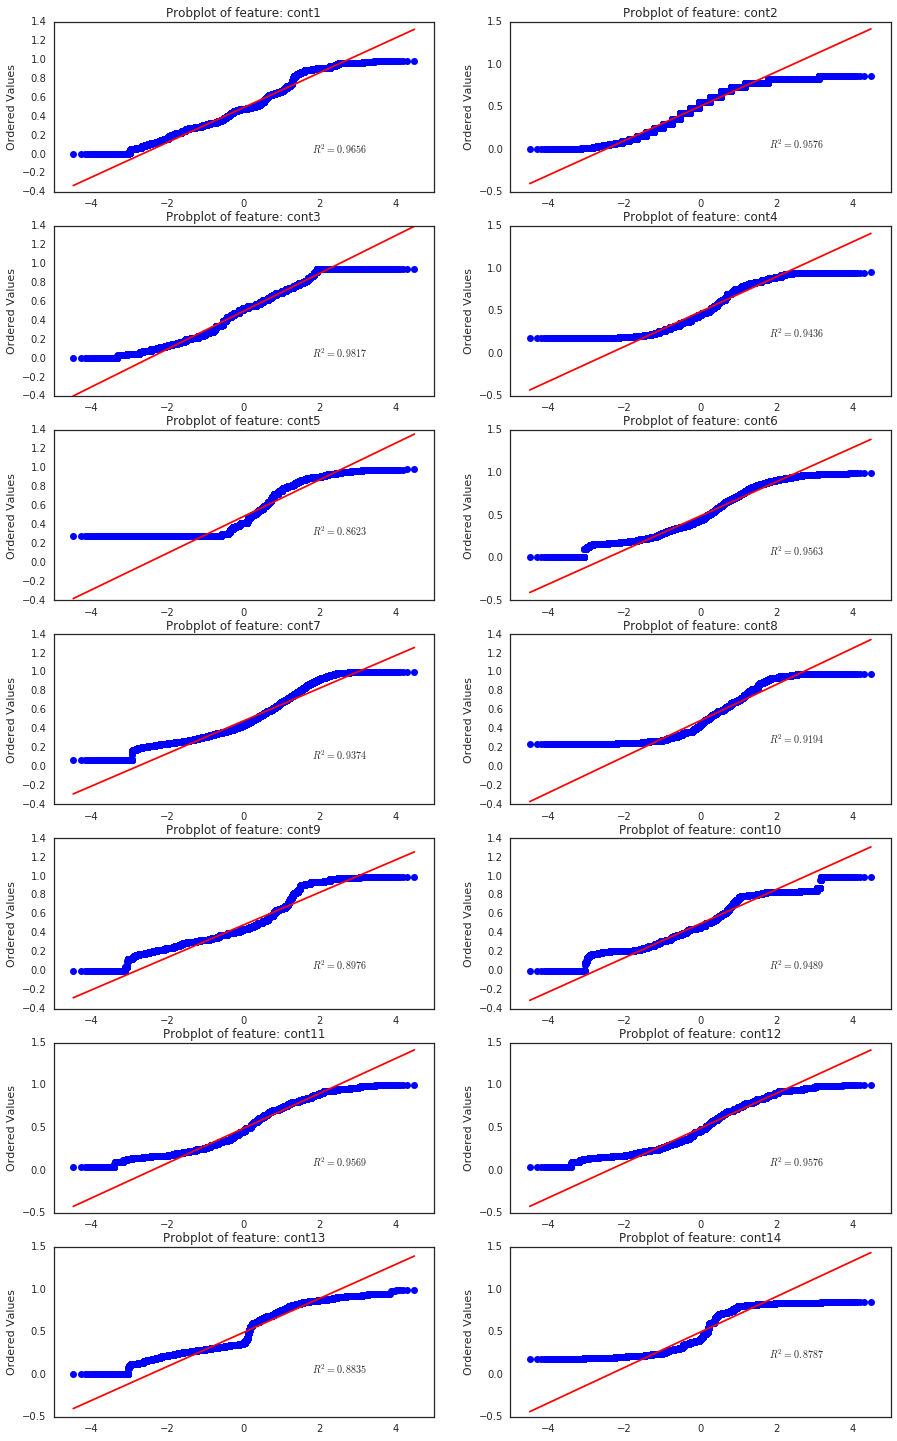

In [47]:
import matplotlib.gridspec as gridspec


plt.figure(figsize=(15,25))
gs = gridspec.GridSpec(7, 2)
for i, cn in enumerate(cont_columns.columns):
    ax = plt.subplot(gs[i])
    stats.probplot(train[cn], dist = stats.norm, plot = ax)
    ax.set_xlabel('')
    ax.set_title('Probplot of feature: cont' + str(i+1))
plt.show()

In [7]:
#attempt to do transformation on continuous variables to get the normal distribution.
#Inspired from https://www.kaggle.com/snmateen/allstate-claims-severity/simple-eda-feature-transformations

test=test.drop(['id'], axis =1)
target = train['loss']
train = train.drop(['loss','id'], axis = 1)
print(test.shape)
print(train.shape)

(125546, 130)
(188318, 130)


In [8]:
train_test = pd.concat((train, test)).reset_index(drop=True)

In [9]:
COMB_FEATURE = 'cat80,cat87,cat57,cat12,cat79,cat10,cat7,cat89,cat2,cat72,' \
               'cat81,cat11,cat1,cat13,cat9,cat3,cat16,cat90,cat23,cat36,' \
               'cat73,cat103,cat40,cat28,cat111,cat6,cat76,cat50,cat5,' \
               'cat4,cat14,cat38,cat24,cat82,cat25'.split(',')

def encode(charcode):
    r = 0
    ln = len(str(charcode))
    for i in range(ln):
        r += (ord(str(charcode)[i]) - ord('A') + 1) * 26 ** (ln - i - 1)
    return r



In [ ]:
import itertools
for comb in itertools.combinations(COMB_FEATURE, 2):
    feat = comb[0] + "_" + comb[1]
    train_test[feat] = train_test[comb[0]] + train_test[comb[1]]
    train_test[feat] = train_test[feat].apply(encode)
    

categorical_feats = train_test.select_dtypes(include=['object'])

print('')
for col in categorical_feats:
    print('Analyzing Column:', col)
    train_test[col] = train_test[col].apply(encode)



In [13]:
train_test['cont1'], _ = stats.boxcox(train_test['cont1'])
train_test['cont4'], _ = stats.boxcox(train_test['cont4'])
train_test['cont5'], _ = stats.boxcox(train_test['cont5'])
train_test['cont6'], _ = stats.boxcox(train_test['cont6'])
train_test['cont7'], _ = stats.boxcox(train_test['cont7'])
train_test['cont8'], _ = stats.boxcox(train_test['cont8'])
train_test['cont9'], _ = stats.boxcox(train_test['cont9'])
train_test['cont10'], _ = stats.boxcox(train_test.cont10 +1)
train_test['cont11'], _ = stats.boxcox(train_test['cont11'])
train_test['cont12'], _ = stats.boxcox(train_test['cont12'])
train_test['cont2'] = np.tan(train_test['cont2'])
train_test['cont13'] = np.abs(train.cont13 - np.mean(train.cont13))
train_test['cont14'] = np.abs(train.cont14 - np.mean(train.cont14))

# Model

In [11]:
ID = 'id'
TARGET = 'loss'
NFOLDS = 5
SEED = 0
NROWS = None

In [11]:
y_train = target.ravel()

In [ ]:
#copied from https://www.kaggle.com/iglovikov/allstate-claims-severity/xgb-1114/code         
# def encode(charcode):
#     r = 0
#     ln = len(str(charcode))
#     for i in range(ln):
#         r += (ord(str(charcode)[i]) - ord('A') + 1) * 26 ** (ln - i - 1)
#     return r
            
    
    
    
    
for column in train_cat.columns:
    if train[column].nunique() != test[column].nunique():
        set_train = set(train[column].unique())
        set_test = set(test[column].unique())
        remove_train = set_train - set_test
        remove_test = set_test - set_train

        remove = remove_train.union(remove_test)


        def filter_cat(x):
            if x in remove:
                return np.nan
            return x


        train_test[column] = train_test[column].apply(lambda x: filter_cat(x), 1)

        train_test[column] = train_test[column].apply(lambda x: filter_cat(x), 1) 

In [12]:
#essemble models, inspired from https://www.kaggle.com/mmueller/allstate-claims-severity/stacking-starter/run/390867/code

features = train.columns

cats = [feat for feat in features if 'cat' in feat]
for feat in cats:
    train_test[feat] = pd.factorize(train_test[feat], sort=True)[0]


In [13]:
ntrain = train.shape[0]
ntest = test.shape[0]
x_train = np.array(train_test.iloc[:ntrain,:])
x_test = np.array(train_test.iloc[ntrain:,:])

kf = KFold(ntrain, n_folds=NFOLDS, shuffle=True, random_state=SEED)


class SklearnWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)


class XgbWrapper(object):
    def __init__(self, seed=0, params=None):
        self.param = params
        self.param['seed'] = seed
        self.nrounds = params.pop('nrounds', 250)

    def train(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, label=y_train)
        self.gbdt = xgb.train(self.param, dtrain, self.nrounds)

    def predict(self, x):
        return self.gbdt.predict(xgb.DMatrix(x))


def get_oof(clf):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)



In [28]:
et_params = {
    'n_jobs': 16,
    'n_estimators': 100,
    'max_features': 0.5,
    'max_depth': 12,
    'min_samples_leaf': 2,
}

rf_params = {
    'n_jobs': 16,
    'n_estimators': 100,
    'max_features': 0.2,
    'max_depth': 8,
    'min_samples_leaf': 2,
}

xgb_params = {
    'seed': 2016,
    'colsample_bytree': 0.7,
    'silent': 1,
    'subsample': 0.7,
    'learning_rate': 0.075,
    'objective': 'reg:linear',
    'max_depth': 7,
    'num_parallel_tree': 1,
    'min_child_weight': 1,
    'eval_metric': 'mae',
    'nrounds': 350
}

In [29]:
xg = XgbWrapper(seed=SEED, params=xgb_params)
et = SklearnWrapper(clf=ExtraTreesRegressor, seed=SEED, params=et_params)
rf = SklearnWrapper(clf=RandomForestRegressor, params=rf_params)

In [30]:
xg_oof_train, xg_oof_test = get_oof(xg)
et_oof_train, et_oof_test = get_oof(et)
rf_oof_train, rf_oof_test = get_oof(rf)

In [34]:
def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(preds), np.exp(labels))

In [38]:
x_train = np.concatenate((xg_oof_train, et_oof_train, rf_oof_train), axis=1)
x_test = np.concatenate((xg_oof_test, et_oof_test, rf_oof_test), axis=1)
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test)

# xgb_params = {
#     'seed': 1,
#     'colsample_bytree': 0.7,
#     'silent': 1,
#     'subsample': 0.7,
#     'learning_rate': 0.03,
#     'objective': 'reg:linear',
#     'max_depth': 12,
#     'num_parallel_tree': 1,
#     'min_child_weight': 100,
#     'eval_metric': 'mae',
# }

RANDOM_STATE = 2016
params = {
        'seed': 1,
        'colsample_bytree': 0.7,
        'silent': 1,
        'subsample': 0.7,
        'learning_rate': 0.03,
        'objective': 'reg:linear',
        'max_depth': 12,
        'min_child_weight': 100,
        'booster': 'gbtree'}



res = xgb.cv(xgb_params, dtrain, num_boost_round=10000, nfold=10, stratified=False,
             early_stopping_rounds=50, verbose_eval=1, show_stdv=True)

#best_nrounds = res.shape[0] - 1
cv_mean = res.iloc[-1, 0]
cv_std = res.iloc[-1, 1]

gbdt = xgb.train(xgb_params, dtrain, 1002)

submission = pd.read_csv('sample_submission.csv')
submission.iloc[:, 1] = np.exp(gbdt.predict(dtest))-200
submission.to_csv('xgstacker_starter_v2_2.sub.csv', index=None)


[0]	train-mae:6.75238+0.000578284	test-mae:6.75236+0.00561604
[1]	train-mae:6.24603+0.00055226	test-mae:6.246+0.00563168
[2]	train-mae:5.77761+0.000534431	test-mae:5.77757+0.00561931
[3]	train-mae:5.34434+0.000490513	test-mae:5.34434+0.0056456
[4]	train-mae:4.94357+0.000463424	test-mae:4.94359+0.00565206
[5]	train-mae:4.57286+0.000421604	test-mae:4.57287+0.00568595
[6]	train-mae:4.22995+0.000404405	test-mae:4.22998+0.00569826
[7]	train-mae:3.91276+0.000367791	test-mae:3.9128+0.00573775
[8]	train-mae:3.61934+0.000329569	test-mae:3.61937+0.00579602
[9]	train-mae:3.34793+0.000297794	test-mae:3.34797+0.00582429
[10]	train-mae:3.09684+0.000277685	test-mae:3.0969+0.00586537
[11]	train-mae:2.8646+0.000264959	test-mae:2.86466+0.00590269
[12]	train-mae:2.64977+0.000253742	test-mae:2.64984+0.00594406
[13]	train-mae:2.45107+0.000213524	test-mae:2.45112+0.00598544
[14]	train-mae:2.26733+0.000204699	test-mae:2.26738+0.00597986
[15]	train-mae:2.09737+0.000196385	test-mae:2.09742+0.00598879
[16]	trai

In [46]:
# import itertools
# COMB_FEATURE = 'cat80,cat87,cat57,cat12,cat79,cat10,cat7,cat89,cat2,cat72,cat81,cat11,cat1,cat13,cat9,cat3,cat16,cat90,cat23,cat36,cat73,cat103,cat40,cat28,cat111,cat6,cat76,cat50,cat5,cat4,cat14,cat38,cat24,cat82,cat25'.split(',')
            



In [ ]:

# for comb in itertools.combinations(COMB_FEATURE, 2):
#     feat = comb[0] + "_" + comb[1]
#     train_test[feat] = train_test[comb[0]] + train_test[comb[1]]
#     train_test[feat] = train_test[feat].apply(encode)

# for col in train_cat:
#     print('Analyzing Column:', col)
#     train_test[col] = train_test[col].apply(encode)

